## Imports

In [1]:
import sys
print("Python Interpreter: ",sys.executable)

import qiskit 
print("Qiskit version: ",qiskit.__version__)

#Qiskit imports
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_gate_map, plot_error_map
from qiskit.circuit import QuantumRegister
from qiskit.quantum_info import Pauli, pauli_basis, SuperOp, PTM, Operator
#from qiskit.providers.aer.noise import NoiseModel, pauli_error
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
#from qiskit.providers.fake_provider import FakeVigoV2
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import Aer, AerSimulator,QasmSimulator
from random import random
from qiskit.transpiler import CouplingMap
#python imports
from random import choice, choices
from itertools import product, permutations, cycle
from scipy.optimize import curve_fit, nnls
from matplotlib import pyplot as plt
import numpy as np
from myfunctions import *

plt.style.use("ggplot")

Python Interpreter:  c:\Users\kchar\OneDrive\Desktop\Uni\Hiwi_Orth\Qiskit\qiskit-venv\Scripts\python.exe
Qiskit version:  1.3.2


## Topology

          
q_0: ─────
          
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          


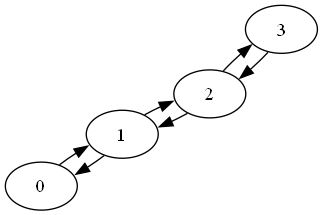

In [2]:
inst_map = [0,1,2,3]
n = 4
layer = QuantumCircuit(n)
layer.cx(1,2)
print(layer.draw())

coupling_list = [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)]
backend = GenericBackendV2(num_qubits=4, coupling_map=coupling_list)
connectivity = backend.coupling_map.graph.subgraph(inst_map)

qiskit.transpiler.CouplingMap(couplinglist=coupling_list).draw()

In [3]:
NUM_BASES = 9
bases = meas_bases(NUM_BASES, n, connectivity)

print("Measurement bases:", np.sort([m.to_label()[::-1] for m in bases]),"\n")
model_terms = get_model_terms(n, connectivity)

Measurement bases: ['XXXX' 'XYXY' 'XZXZ' 'YXYX' 'YYYY' 'YZYZ' 'ZXZX' 'ZYZY' 'ZZZZ'] 

Model terms: ['IIIX' 'IIIY' 'IIIZ' 'IIXI' 'IIXX' 'IIXY' 'IIXZ' 'IIYI' 'IIYX' 'IIYY'
 'IIYZ' 'IIZI' 'IIZX' 'IIZY' 'IIZZ' 'IXII' 'IXXI' 'IXYI' 'IXZI' 'IYII'
 'IYXI' 'IYYI' 'IYZI' 'IZII' 'IZXI' 'IZYI' 'IZZI' 'XIII' 'XXII' 'XYII'
 'XZII' 'YIII' 'YXII' 'YYII' 'YZII' 'ZIII' 'ZXII' 'ZYII' 'ZZII'] 

Number of model terms: 39


## Expectation value

In [4]:
def get_expectation(pauli = Pauli('II'), counts ={}):
        estimator = 0
        counts = counts
        pz = list(reversed([{Pauli("I"):'0'}.get(p,'1') for p in pauli]))
        #compute estimator
        for key in counts.keys():
            k = [i for i in key]            
            #compute the overlap in the computational basis
            sgn = sum([{('1','1'):1}.get((pauli_bit, key_bit), 0) for pauli_bit, key_bit in zip(pz, k)])
            #update estimator
            estimator += (-1)**sgn*counts[key]

        return estimator/sum(counts.values())

## Infidelities

## Pauli Channel Definition


Ein PauliError ist ein klassischer gemischter Kanal, definiert als:

$$
\Lambda(\rho)=\sum_i p_i \cdot P_i \rho P_i
$$

wo $P_i \in\{I, X, Y, Z\}^{\otimes n}$, und $p_i$ die Wahrscheinlichkeiten sind.

In [5]:
n = 4

# Fehlerdefinition: Nur XX auf Qubits 1 & 2
errorops = [Pauli("XX")]
errorprobs = [0.02]

# Erzeuge PauliError und NoiseModel
twoqubit_error = pauli_error([(op, p) for op, p in zip(errorops, errorprobs)] + [(Pauli("II"), 1 - sum(errorprobs))])
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx'])

local_channel = twoqubit_error.to_quantumchannel()
#print(local_channel)

## PTM Definition

Die Pauli Transfer Matrix $\Lambda_{i j}$ eines Kanals $\Lambda$ beschreibt, wie ein Pauli-Operator $P_j$ unter dem Kanal transformiert wird:

$$
\Lambda\left(P_j\right)=\sum_i \Lambda_{i j} P_i
$$


Die Diagonalelemente $\Lambda_{j j}$ geben an, wie stark $P_j$ erhalten bleibt $\rightarrow$ Fidelity $f_j$

$$
f_j = \Lambda_{j j}=\frac{1}{2^n} \operatorname{Tr}\left[P_j^{\dagger} \cdot \Lambda\left(P_j\right)\right]
$$

(256, 256)


Text(0, 0.5, '(1-f)')

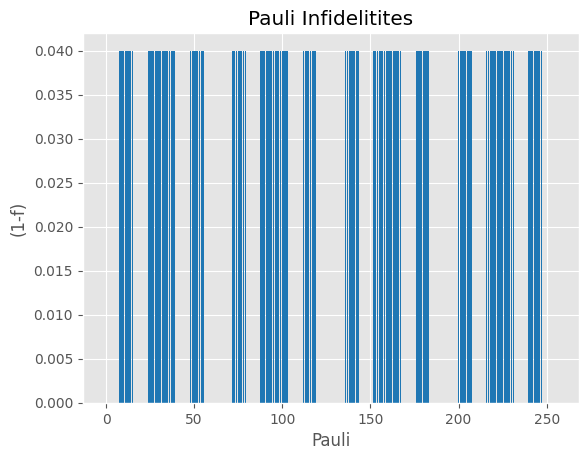

In [6]:
from qiskit.quantum_info import Pauli, SuperOp, PTM, Operator

# Einbetten in 4 Qubits
def embed_channel(local_channel, acting_qubits, total_qubits):
    id_op = SuperOp(Operator(np.eye(2)))
    ops = []
    for i in range(total_qubits):
        if i in acting_qubits:
            ops.append(None)
        else:
            ops.append(id_op)

    embedded = None
    insert_count = 0
    for op in reversed(ops):
        if op is None:
            if insert_count == 0:
                op = SuperOp(local_channel)
            else:
                insert_count += 1
                continue
            insert_count += 1

        if embedded is None:
            embedded = op
        else:
            embedded = embedded.expand(op)

    return embedded

# Kanal einbetten
full_channel = embed_channel(local_channel, [1, 2], 4)

# PTM berechnen
transfer_matrix = PTM(full_channel).data
print(transfer_matrix.shape)  # → (256, 256)


pauli_list = [pauli.to_label() for pauli in pauli_basis(4,  True) ]
real_errors_sort = {}
# Pauli transfer matrices 

#pauli_list = np.sort([m.to_label()[::-1] for m in model_terms])
#print(pauli_list)

for i,pauli in enumerate(sorted(pauli_list)):
    real_errors_sort[Pauli(pauli)] = transfer_matrix[i][i]
    plt.bar(i, (1-transfer_matrix[i][i]).real, color="tab:blue")


# print(real_errors_sort)
plt.title("Pauli Infidelitites")
plt.xlabel("Pauli")
plt.ylabel("(1-f)")


In [7]:
# QASM simulator is considered, we will add the custom noise model to it for simulations
sim = QasmSimulator()

SINGLE = 1
shots = 10000
for term in model_terms:
    circ = instance(n, layer, backend, inst_map, prep_basis=conjugate(term, layer), meas_basis=term,noise_repetitions= SINGLE,transpiled=False)
    result_single_counts = sim.run(circ,noise_model=noise_model, shots = shots).result().get_counts()


In [8]:
def get_expectation(pauli, **metadata):
        estimator = 0
        counts = metadata['counts']
        #rostring = metadata['rostring']
        #compute locations of non-idetity terms (reversed indexing)
        pz = list(reversed([{Pauli("I"):'0'}.get(p,'1') for p in pauli]))
        #compute estimator
        for key in counts.keys():
            k = [i for i in key]            
            #compute the overlap in the computational basis
            sgn = sum([{('1','1'):1}.get((pauli_bit, key_bit), 0) for pauli_bit, key_bit in zip(pz, k)])
            #update estimator
            estimator += (-1)**sgn*counts[key]

        return estimator/sum(counts.values())

def weight(pauli):
    return len([p for p in pauli if not p==Pauli("I")])

#return True if Paulis differ by "I"s only
def disjoint(pauli1, pauli2):
    return all([p1==p2 or (p1 == Pauli("I") or p2 == Pauli("I")) for p1,p2 in zip(pauli1, pauli2)])

#return True if pauli requires a degeracy lifting measurement based on the conditions described above
def is_single(pauli, layer):
    pair = conjugate(pauli, layer)
    return (pauli in model_terms and pair in model_terms) and pauli != pair


#find disjoint operators that can be measured simultaneously to find six bases
pairs = set([frozenset([p,conjugate(p, layer)]) for p in model_terms if is_single(p, layer)])
#print(pairs)
single_bases = []
for p1,p2 in pairs:
    
    for i,pauli in enumerate(single_bases):
        if disjoint(pauli, p1) and disjoint(pauli, p2):
            single_bases[i] = nophase(pauli.compose(p2))
            break
    else:
        if weight(p1)<=weight(p2):
            single_bases.append(p2)
        else:
            single_bases.append(p1)

    #print(single_bases)

for p in model_terms:
    pair = conjugate(p, layer)
    if pair not in model_terms:
        single_bases.append(p)

print("bases for singles: ",single_bases)

bases for singles:  [Pauli('IZZI'), Pauli('IYXI'), Pauli('IXXI'), Pauli('IZXI'), Pauli('IXYI'), Pauli('IYZI'), Pauli('IIYY'), Pauli('YZII'), Pauli('IIYX'), Pauli('IIXX'), Pauli('IIYZ'), Pauli('ZZII'), Pauli('XZII'), Pauli('ZYII'), Pauli('YYII'), Pauli('IIXZ'), Pauli('XYII'), Pauli('IIXY')]


In [9]:
SINGLE = 1
circuits = []
depths = [2,4,8,16,32,64]
samples = [100]*len(depths)
print(samples)
single_samples = 250
total = len(bases)*sum(samples)+len(single_bases)*single_samples

j=0
for basis, (d,s) in product(bases, zip(depths,samples)):
    for i in range(s):
        circ = instance(n, layer, backend, inst_map,basis, basis, d,transpiled=True)
        circ.metadata["type"] = "double"
        circuits.append(circ)

        j+=1
        print(j,"/",total, end='\r')

for basis, s in product(single_bases, range(single_samples)):
    circ = instance(n, layer, backend, inst_map,conjugate(basis, layer),basis,SINGLE,transpiled=True)
    circ.metadata["type"] = "single"
    circuits.append(circ)

    j+=1
    print(j,"/",total, end='\r')

print(len(circuits))

[100, 100, 100, 100, 100, 100]
9900 / 9900


In [10]:
results = sim.run(circuits, shots=1000, noise_model = noise_model).result().get_counts()

#Shows whether two pauli operators can be measured simultaneously
def simultaneous(pauli1, pauli2):
    return all([p1==p2 or p2 == Pauli("I") for p1,p2 in zip(pauli1, pauli2)])

#Gives a list of all terms in the model that can be measured simultaneously with pauli
def sim_meas(pauli):
    return [term for term in model_terms if simultaneous(pauli, term)]

#Gives a list of all terms, in the sparse model or not, that can be measured simultaneously
#This is used to overdeteremine the model, but since it grows as 2^n, this method can always be
#replaced with sim_meas
def all_sim_meas(pauli):
    return [Pauli("".join(p)) for p in product(*zip(pauli.to_label(), "I"*n))]
#all_sim_meas = sim_meas

In [11]:
#Sort into single and double measurements
for res,circ in zip(results, circuits):
    circ.metadata["counts"] = res

singles = []
doubles = []
for circ in circuits:
    datum = circ.metadata
    type = datum["type"]
    datum.pop("type")
    if type == "single":
        singles.append(datum)
    elif type == "double":
        doubles.append(datum)

In [12]:
#reorder by measurement basis
basis_dict = {}
#improve execution time by storing runs of all_sim_meas for each basis
sim_measurements = {}
for datum in doubles:
    #print(datum)
    #get run data
    basis = datum['prep_basis']
    depth = datum['depth']
    #find simultaneous measurements
    if not basis in sim_measurements:
        sim_measurements[basis] = all_sim_meas(basis)
    #aggregate expectation value data for each simultaneous measurement
    for pauli in sim_measurements[basis]:

        expectation = get_expectation(pauli, **datum)
        #set up dictionary
        if not pauli in basis_dict:
            basis_dict[pauli] = {"expectation":[0 for d in depths], "total":[0 for d in depths]}
        
        #add expectation value to result at depth
        basis_dict[pauli]["expectation"][depths.index(depth)] += expectation
        basis_dict[pauli]["total"][depths.index(depth)] += 1

        pair = conjugate(pauli, layer)
        #if pair not in model_terms:
            #basis_dict[pair] = {}
        

expfit = lambda x,a,b : a*np.exp(-x*b)
#for each of the simultaneous measurements

for p in model_terms:
    pair = conjugate(p,layer)
    if pair not in basis_dict.keys():
        basis_dict[pair] = {}


for key in basis_dict.keys():
    for i,d in enumerate(depths):
        #divide by total
        if "expectation" in basis_dict[key]:
            basis_dict[key]["expectation"][i] /= basis_dict[key]["total"][i]
    #try finding exponential fit, default to ideal if no fit found
    try:
        popt, pcov = curve_fit(expfit, depths, basis_dict[key]["expectation"], p0=[.9,.01])
    except:
        popt = 1,0

    #store fidelity and SPAM coefficients
    fidelity = min(1.0, max(0.0, expfit(1,*popt)))
    spam = min(1.0, max(0.0, popt[0]))

    basis_dict[key]["fidelity"] = fidelity
    basis_dict[key]["SPAM"] = spam
    
    pair = conjugate(key, layer)
    if key in model_terms and pair not in model_terms:
        basis_dict[pair]["fidelity"] = fidelity
        basis_dict[pair]["SPAM"] = spam
        basis_dict[pair]["type"] = "pair"

    #record whether measurement appears as a pair or as a single fidelity
    if key != pair:
        basis_dict[key]["type"] = "pair"
    else:
        basis_dict[key]["type"] = "single"

In [13]:
singles_dict = {} #store results of single measurements
sim_measurements = {}
for datum in singles:
    meas_basis = datum['meas_basis']
    prep_basis = datum['prep_basis']
    #find terms that can be measured simultaneously
    if not meas_basis in sim_measurements:
        sim_measurements[meas_basis] = []
        for term in model_terms:
            if simultaneous(meas_basis, term) and simultaneous(prep_basis, conjugate(term, layer)):
                sim_measurements[meas_basis].append(term)
    #aggregate data together
    for meas in sim_measurements[meas_basis]:
        expectation = get_expectation(meas, **datum)
        #the measurement basis SPAM coefficients are closer because the readout noise, combined
        #with the noise from the last layer, is greater than the state preparation noise
        #print( meas, ', ', np.abs(expectation), ', ', basis_dict[meas]["SPAM"])
        fidelity = np.min([1.0,np.abs(expectation)/basis_dict[meas]["SPAM"]])
        #singles_dict[meas] += fidelity/single_samples
        
        if meas not in singles_dict:
            singles_dict[meas] = []

        singles_dict[meas].append(fidelity)

#add singles data to basis_dict
for key in singles_dict:
    avg_fidelity = np.mean(singles_dict[key])
    basis_dict[key]['fidelity'] = avg_fidelity
    basis_dict[key]['type'] = "single"
    

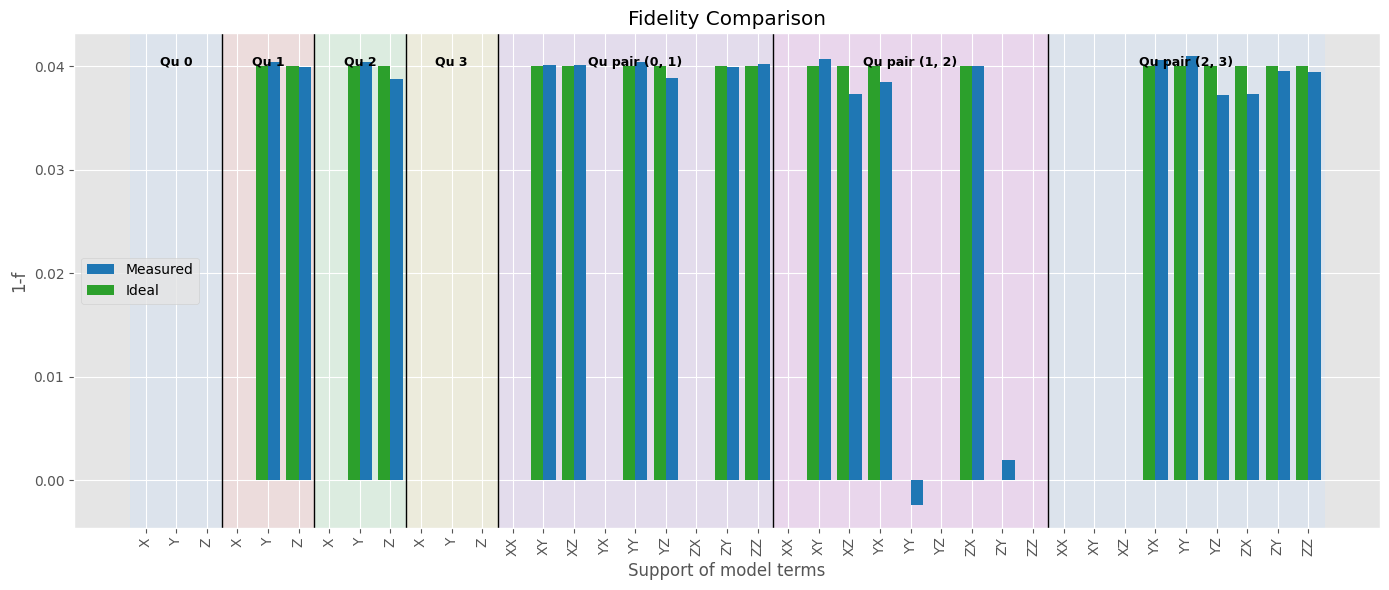

Pauli      Measured   Ideal      Δ        Type   Conj   Conj ∈ model_terms
------------------------------------------------------------


In [14]:
fidelities = []
fidelities_calculated = []
for p in model_terms:
    fid = basis_dict[p]['fidelity']
    
    if(basis_dict[p]['type'] == 'pair'):
        pair = conjugate(p, layer)
        fid = fid**2/basis_dict[pair]['fidelity']
            
    fidelities.append(np.real(fid))
    fidelities_calculated.append(np.real(real_errors_sort[p]))
    
Infidelities = []
Infidelities_calculated = []

for i in range(len(fidelities)):
    Infidelities.append(1-np.real(fidelities[i]))
    Infidelities_calculated.append(1-np.real(fidelities_calculated[i]))

plot_fidelities_grouped_by_qubit(model_terms, Infidelities, Infidelities_calculated, coupling_list, title="Fidelity Comparison", ylabel= "1-f")
check_fidelity_discrepancies(model_terms,layer, basis_dict, fidelities_calculated, fidelities)

This is B1 list needed to build the M1 matrix: ['IIYY', 'ZXII', 'IXXI', 'YZII', 'IIYX', 'IIIX', 'IIYI', 'XXII', 'IIXX', 'IIYZ', 'ZZII', 'IYXI', 'IXZI', 'IZXI', 'IIIZ', 'XZII', 'IYYI', 'ZYII', 'IZZI', 'YYII', 'IZII', 'IZYI', 'YIII', 'IIZI', 'YXII', 'IYII', 'IIIY', 'IIXI', 'IYZI', 'IIZZ', 'ZIII', 'IIXZ', 'XYII', 'IIZY', 'IIXY', 'IXYI', 'IXII', 'IIZX', 'XIII']
This is B2 list needed to build the M2 matrix: ['IIYY', 'ZXII', 'IXXI', 'YZII', 'IIYX', 'IIIX', 'IIYI', 'XXII', 'IIXX', 'IIYZ', 'ZZII', 'IYXI', 'IXZI', 'IZXI', 'IIIZ', 'XZII', 'IZXI', 'ZYII', 'IZZI', 'YYII', 'IZII', 'IYXI', 'YIII', 'IIZI', 'YXII', 'IYII', 'IIIY', 'IIXI', 'IYZI', 'IIZZ', 'ZIII', 'IIXZ', 'XYII', 'IIZY', 'IIXY', 'IXYI', 'IXII', 'IIZX', 'XIII']
[('IIYY', 'IIYY'), ('ZXII', 'ZXII'), ('IXXI', 'IXXI'), ('YZII', 'YZII'), ('IIYX', 'IIYX'), ('IIIX', 'IIIX'), ('IIYI', 'IIYI'), ('XXII', 'XXII'), ('IIXX', 'IIXX'), ('IIYZ', 'IIYZ'), ('ZZII', 'ZZII'), ('IYXI', 'IYXI'), ('IXZI', 'IXZI'), ('IZXI', 'IZXI'), ('IIIZ', 'IIIZ'), ('XZII', 

c:\Users\kchar\OneDrive\Desktop\Uni\Hiwi_Orth\Qiskit\qiskit-venv\lib\site-packages\numpy\lib\_function_base_impl.py:644: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


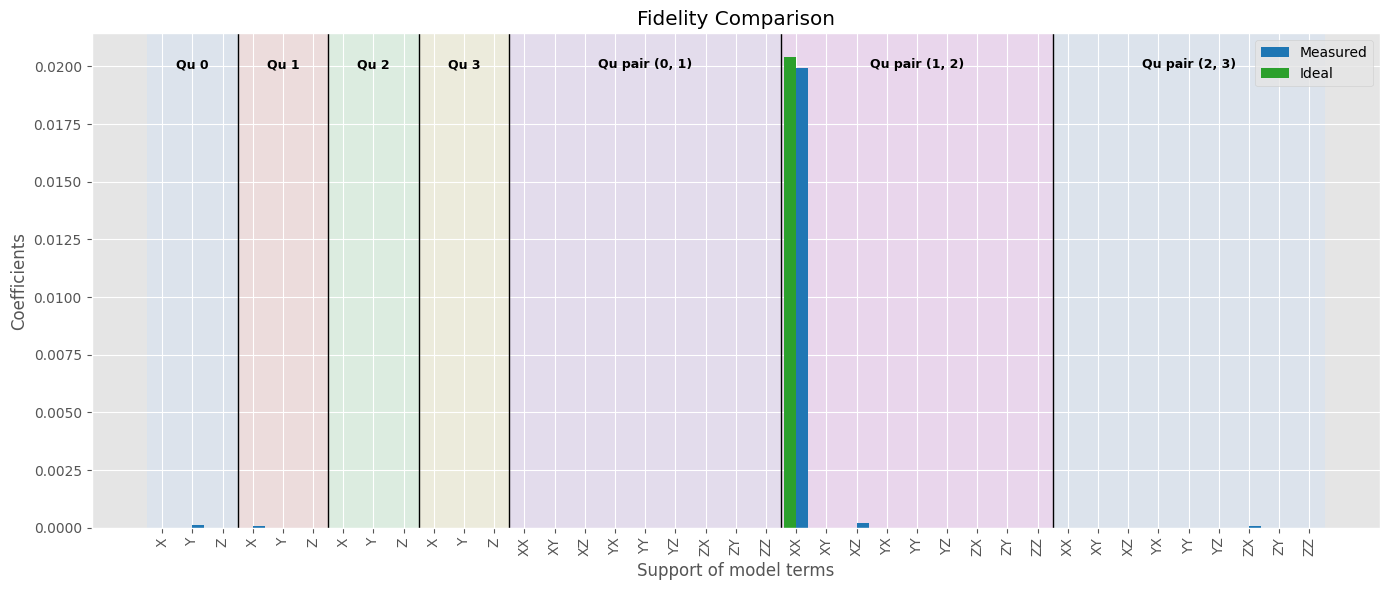

In [15]:
f1 = []
f2 = []
fidelities = []
for key in model_terms:
    f1.append(key)
    fidelities.append(basis_dict[key]['fidelity'])
    
    if basis_dict[key]["type"] == "pair":
        pair = conjugate(key, layer)
        f2.append(pair)
    else:
        f2.append(key)

print("This is B1 list needed to build the M1 matrix:",([f.to_label() for f in f1]))
print("This is B2 list needed to build the M2 matrix:",([f.to_label() for f in f2]))
B1B2= []
for i,j in zip(f1,f2):
    if i.to_label()==j.to_label():
        B1B2.append((i.to_label(),j.to_label()))
    #if i==j:

print(B1B2)

sprod = lambda a,b: int(a.anticommutes(b))
M1 = [[sprod(a,b) for a in model_terms] for b in f1]
M2 = [[sprod(a,b) for a in model_terms] for b in f2]
# The rank of the M matrix has to be maximum, i.e., equal to model terms to find unique solution
np.linalg.matrix_rank(np.add(M1,M2))

coeffs,rnorm = nnls(np.add(M1,M2), -np.log(fidelities))
real_coeffs, real_rnorm = nnls(M1, -.5*np.log([real_errors_sort[term] for term in f1]))

plot_fidelities_grouped_by_qubit(model_terms, coeffs, real_coeffs, coupling_list, title="Fidelity Comparison")